In [1]:
import pandas as pd
import csv
import os
import numpy as np
import pytz
import datetime
from xlsxwriter.workbook import Workbook
from xlsxwriter import Workbook
import time
from scipy import integrate, stats
import scipy
import matplotlib.pyplot as plt
from functools import reduce
from sklearn import preprocessing
from sklearn.preprocessing import MinMaxScaler
import re
import collections

# %matplotlib inline

In [2]:
Working_dir = os.getcwd()
Data_dir = os.path.join(Working_dir, 'Raw data')
Data_prep_dir = os.path.join(Working_dir, 'Preprocessed data')
Output_dir = os.path.join(Working_dir, 'Analysis')
Plots_dir = os.path.join(Output_dir, 'Plots')

In [3]:
nodes_file_names = ['May2018_idle.csv', 'June2018_idle.csv', 'July2018_idle.csv', \
                    'September2018.csv', 'October2018.csv', 'November2018.csv', \
                    'December2018.csv' , 'January2019.csv', 'February2019.csv']
nodes_df_names = [item.split('.')[0] for item in nodes_file_names]
nodes_stats_ = 'nodes_stats_'
node_df_may = pd.read_csv( os.path.join( Output_dir, nodes_stats_ + 'May2018_idle.csv'), delimiter=";", header=0, index_col=0 )
node_names = node_df_may.columns.values
idle_power_mean = 185.18
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']

### Read stats with "temp_no_outliers" or "temp_variation"
- "temp_no_outliers" 
        large infrequent (appear in <1e-1 % of cases for each month) variations between successive measurements that happen within are deleted
- "temp_variation" 
        calculated variation of temperature for evey node within a month
        dropped cases when abs(temp) > 100
        

In [4]:
# name_suffix = '_temp_no_outliers'
name_suffix = '_temp_variation'
# name_suffix = ''

In [5]:
# Read preprocessed data
data_prep_df = {}
for df_name in nodes_df_names:
        data_prep_df[df_name] = pd.read_csv( os.path.join( Data_prep_dir, df_name + name_suffix + '.csv'), \
                                             delimiter=";", header=0 )

In [6]:
nodes_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, nodes_stats_ + df_name + name_suffix + '.csv' ), \
                                         delimiter=";", header=0, index_col=0)
    to_drop_ix = np.unique(np.append(\
                                     np.where(nodes_df_dict[df_name].loc['dcenergy_error_percent', :].isna())[0], \
                                     np.where(nodes_df_dict[df_name].loc['dcenergy_error_percent', :] > 5.)[0]))
    to_drop = nodes_df_dict[df_name].iloc[:,to_drop_ix].columns.values
    nodes_df_dict[df_name].drop(columns=to_drop, inplace=True)
    
nodes_no_drop_df_dict = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_no_drop_df_dict[df_name] = pd.read_csv(os.path.join( Output_dir, nodes_stats_ + df_name + name_suffix + '.csv' ), \
                                         delimiter=";", header=0, index_col=0)

In [7]:
nodes_summary_df         = pd.read_csv(os.path.join( Output_dir, \
                                                    'nodes_summary_all_months' + name_suffix + '.csv'), sep=";", index_col=0 )
nodes_summary_no_drop_df = pd.read_csv(os.path.join( Output_dir, \
                                                    'nodes_summary_all_months_no_drop' + name_suffix + '.csv'), sep=";" ) 

In [ ]:
all_nodes_dict = {}
for node in node_names:
    all_nodes_dict[node] = pd.read_csv( os.path.join( Data_prep_dir, \
                                                     'Nodes', \
                                                     'Node_'+str(int(node.split('x')[1])) + name_suffix + '.csv'), \
                                        sep=";", index_col=0 ) 

In [28]:
# # Read preprocessed data for every node separately for every month
# all_nodes_by_month_dict = {}
# for df_name in nodes_df_names:
#     all_nodes_by_month_dict[df_name] = {}
#     for node in node_names:
#         node_df = data_prep_df[df_name].copy()
#         all_nodes_by_month_dict[df_name][node] = node_df[node_df.nodename == node].copy()

## Preprocessing - all the months

http://benalexkeen.com/working-with-timezones-in-python/

In [16]:
winter_dt = datetime.datetime(2017, 1, 1, 14, 0)
print(winter_dt.strftime("Winter Local Time: %H:%M"))

summer_dt = datetime.datetime(2017, 7, 1, 14, 0)
print(summer_dt.strftime("Summer Local Time: %H:%M"))

local_tz = pytz.timezone('Europe/Berlin')
target_tz = pytz.timezone('UTC')

winter_dt = local_tz.localize(winter_dt)
summer_dt = local_tz.localize(summer_dt)

winter_dt = target_tz.normalize(winter_dt)
summer_dt = target_tz.normalize(summer_dt)

print(winter_dt.strftime("Winter UTC Time: %H:%M"))
print(summer_dt.strftime("Summer UTC Time: %H:%M"))

Winter Local Time: 14:00
Summer Local Time: 14:00
Winter UTC Time: 13:00
Summer UTC Time: 12:00


In [10]:
def fmt_converter(x):
    fmt_summer = '%a %d %b %H:%M:%S CEST %Y'
    fmt_winter = '%a %d %b %H:%M:%S CET %Y'
    
    datetime_result = datetime.datetime.now()

    if 'CEST' in x:
        datetime_result = datetime.datetime.strptime(x, fmt_summer)
    else: 
        datetime_result = datetime.datetime.strptime(x, fmt_winter)
    return datetime_result

def utc_converter(x):
    local_tz = pytz.timezone('Europe/Rome')
    target_tz = pytz.timezone('UTC')
    datetime_init = fmt_converter(x)
    datetime_localized = local_tz.localize(datetime_init)
    datetime_result = target_tz.normalize(datetime_localized)
    return datetime_result

def unix_converter(x):
    return utc_converter(x).timestamp()

In [11]:
data_prep_df = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    node_df = pd.read_csv( os.path.join( Data_dir, file_name), delimiter=";", header=0 )
    node_df.dcenergy = node_df.dcenergy.apply(lambda x: float(x.replace(",", ".")) )
    node_df.loc[:,'timestamp_py'] = node_df.tempo.apply(fmt_converter)
    node_df.loc[:,'unix_timestamp'] = node_df.tempo.apply(unix_converter)
    node_df.iloc[:,3:-1] = node_df.iloc[:, 3:-1].\
        apply(lambda y: y.\
                apply(lambda x: \
                      float(x.replace(",", ".")) if type(x)==str else x ))
    node_df.drop(columns='timestamp_measure', inplace=True)
    node_df.columns = node_df.columns.str.replace('amb_temp', 'inlet_temp')
    data_prep_df[df_name] = node_df.copy()
    # node_df.to_csv(path_or_buf=os.path.join( Data_prep_dir, month + name_suffix +'.csv'), sep=';', index=False)

In [21]:
# for file_name, month in zip(nodes_file_names, nodes_df_names):
#     data_prep_df[month].to_csv( path_or_buf=os.path.join( Data_prep_dir, month + name_suffix +'.csv'), sep=';', index=False )

### Exclude outliers from temperature measurements based on probability and abs value of drops/rises

### Done and discarded
#### Find nodes and time with abrupt temperature variation 


1. Study fluctuations of temperature by node
    - Clean the values: 0, nan, +/-inf -> skip for each temp type 
    - Create a dictionary with node names as keys, and all thermal info about the nodes
        In the rows where the data about one characterisic is not available, insert np.nan for further easier use
    - Add {temp_type}_next_hop columns, for temp_type $\in$ {CPU1, CPU2, amb, exh}
2. Study outliers for future stats tuning - find a range for appropriate thermal values and apply for preprocessed data while calculating stats with the previous algorithm
    - min and max of temp_type fluctuations and temperature occurrences
    
Output:
- more precise temperature graphs and metrics calculations

In [16]:
# Inlet temperature abs variation <= 10
# Other temperature abs variation | probability of variation >= 1e-3
# 1e-3 - from the counter - such values appear 1-2 times

def assign_temp_ranges( temp_values, temp_type, unixtime_values, time_bn_meas_mins=30 ):
    temp_fluctuations = pd.Series( data = ( temp_values[1:].values - temp_values[:-1].values ), \
                               index = temp_values.index[1:] )
    temp_fluctuations_new = temp_fluctuations.copy()
    
    
        counter       = collections.Counter(temp_fluctuations)
        keys, values  = zip( *sorted( zip( [*counter.keys()], [*counter.values()] )))
        frequency     = values / np.float64( sum( values ))
        outliers_keys = np.array( keys )[np.intersect1d( np.where( frequency < np.float64( 1e-1 ) )[0], \
                                                         np.where( ( keys > np.float64( 20 )) | \
                                                                   ( keys < np.float64( -20 )))[0] )]
        
        if ( outliers_keys.size != 0 ):
            temp_values[ temp_fluctuations[temp_fluctuations.isin( outliers_keys )].index.values ] = np.nan
            temp_fluctuations_new[ temp_fluctuations[temp_fluctuations.isin( outliers_keys )].index.values ] = np.nan
        
        # Check that time difference between consecutive variance entries < chosen interval 
        # (30 mins by default)
    time_difference   = ( unixtime_values[1:].values - \
                        unixtime_values[:-1].values )
    time_limit = time_difference < time_bn_meas_mins * 60
    temp_fluctuations_new = temp_fluctuations_new[time_limit]
        
    return temp_values, temp_fluctuations, temp_fluctuations_new

## Add temperature variation to the preprocessed files
Clenasing check-up 

In [ ]:
for i in range(len(nodes_df_names)):
    counter = collections.Counter(data_prep_df[nodes_df_names[i]][data_prep_df[nodes_df_names[i]].exh_temp > 80].exh_temp)
    print(nodes_df_names[i], '\t', counter)

In [174]:
temp_titles = ['Exhaust', 'Inlet', 'CPU 1', 'CPU 2']
for month in nodes_df_names:
    print( month )
    for temp_type in temp_types:
        print( temp_type )

        one_month_df = data_prep_df[month].copy()
        for node in node_names:
            one_node_df = one_month_df[one_month_df.nodename == node].copy()
            
            temp_values = one_node_df.loc[:, temp_type+'_temp']
            temp_outliers_ix = temp_values[( abs( temp_values ) > 100 ) | ( temp_values == 0 )].index
            if ( len( temp_outliers_ix ) > 0 ):
                one_month_df.loc[temp_outliers_ix, temp_type+'_temp'] = np.nan
            temp_values = one_node_df.loc[:, temp_type+'_temp'].dropna()
                
            variation = pd.Series( data = ( temp_values[1:].values - temp_values[:-1].values ), \
                               index = temp_values.index[1:] )
            
            one_month_df.loc[one_node_df.index, temp_type+'_temp_variation'] = np.nan
            one_month_df.loc[variation.index, temp_type+'_temp_variation']   = variation.copy()
            
        data_prep_df[month] = one_month_df.copy()

    print( '----------------------\n' )

May2018_idle
exh
inlet
cpu1
cpu2
----------------------

June2018_idle
exh
inlet
cpu1
cpu2
----------------------

July2018_idle
exh
inlet
cpu1
cpu2
----------------------

September2018
exh
inlet
cpu1
cpu2
----------------------

October2018
exh
inlet
cpu1
cpu2
----------------------

November2018
exh
inlet
cpu1
cpu2
----------------------

December2018
exh
inlet
cpu1
cpu2
----------------------

January2019
exh
inlet
cpu1
cpu2
----------------------

February2019
exh
inlet
cpu1
cpu2
----------------------



In [178]:
for month in nodes_df_names:
    if ( 'cresco6x114' in data_prep_df[month].nodename.unique() ):
        print(month)
        index_node_to_drop = data_prep_df[month][data_prep_df[month].nodename == 'cresco6x114'].index
        data_prep_df[month].drop( index_node_to_drop, inplace=True )

In [8]:
# for month in nodes_df_names:
#     print(data_prep_df[month].filter(regex='_temp_').columns.values, data_prep_df[month].filter(regex='_temp_').min())

In [187]:
for file_name, month in zip(nodes_file_names, nodes_df_names):
    data_prep_df[month].to_csv( path_or_buf=os.path.join( Data_prep_dir, month + name_suffix +'.csv'), sep=';', index=False )

### Imbalance between inlet and exhaust temperature
Exh<inlet

In [19]:
df_exh_less_inlet = pd.DataFrame()
for month in nodes_df_names:
    node_df = data_prep_df[month].copy()
    df_exh_less_inlet = df_exh_less_inlet.\
            append(node_df[(node_df.exh_temp_no_outliers < node_df.inlet_temp_no_outliers)])
    print(month, node_df[(node_df.exh_temp_no_outliers < node_df.inlet_temp_no_outliers)].shape[0])

May2018_idle 6
June2018_idle 25
July2018_idle 26
September2018 0
October2018 1
November2018 0
December2018 0
January2019 0
February2019 15


In [20]:
df_exh_less_inlet.shape[0]

73

In [22]:
abs(df_exh_less_inlet.exh_temp_no_outliers - df_exh_less_inlet.inlet_temp_no_outliers).max()

1.0

#### Resume
No need to exclude cases when exh<inlet, because the difference is 1 $^{\circ}$C at max

------------
## Form Node_i.csv - one node, data from all months

In [ ]:
# Read preprocessed data for every node 
# All data about the nodes from several months are in one file
all_nodes_dict = {}
for node in node_names:
    all_nodes_dict[node] = pd.DataFrame()
    for df_name in nodes_df_names:
        node_df = data_prep_df[df_name].copy()
        all_nodes_dict[node] = all_nodes_dict[node].append(node_df[node_df.nodename == node], ignore_index=True)
    all_nodes_dict[node].to_csv( path_or_buf=os.path.join( Data_prep_dir, 'Nodes', \
                                                          'Node_' + str(int(node.split('x')[1])) + name_suffix + '.csv' ), sep=';' )
    if (int(node.split('x')[1]) % 40 == 0):
        print(node)

cresco6x040
cresco6x080
cresco6x120
cresco6x160
cresco6x200


## Read preprocessed data for every node separately for every month

In [ ]:
all_nodes_by_month_dict = {}
for df_name in nodes_df_names:
    all_nodes_by_month_dict[df_name] = {}
    for node in node_names:
        node_df = data_prep_df[df_name].copy()
        all_nodes_by_month_dict[df_name][node] = node_df[node_df.nodename == node].copy()

------
## Energy analysis

In [82]:
def forth_integral(y_values, time):
    return(np.dot(y_values, time))

In [83]:
def error_percentage(a, b):
    if a > 0.:
        return(abs(a-b) / a * 100.)
    else: 
        return(abs(a-b) / b * 100.)

In [84]:
def percentage(a, b):
    return((a / b) * 100.)

## Create dictionary of dataframes to summarize info for every node
One dictionary entry = one dataframe = one month $\ni  \{$ all nodes - columns $\}$

### 1. Create and fill total energy column 
- total_dcenergy
   
   energy difference between last and first measurement for every node, since energy meter shows incremental observations

In [11]:
nodes_df_dict_init = {}
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    # Read preprocessed data
    node_df = data_prep_df[df_name].copy()
    
    # Create df
    nodes_df_dict_init[df_name] = pd.DataFrame(columns = list(node_df.nodename.unique()), index = [], data=0)

In [ ]:
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    # Energy meter difference
    for node in nodes_df_dict_init[df_name].columns.values:
        nodes_df_dict_init[df_name].loc['total_dcenergy', node] = \
            node_df[node_df.nodename == node]['dcenergy'].values[-1] - \
            node_df[node_df.nodename == node]['dcenergy'].values[0]

### 2. Calculate integrals
- System, CPU and memory energy use as integral of corresponding power measurements
- Portion of CPU, memory and other components in energy use - percentage

In [47]:
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name].copy()
    
    for node in nodes_df_dict_init[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        
        # Read time difference between consecutive measurements and convert from seconds to hours
        time_difference = (one_node_df['unix_timestamp'][1:].values -\
            one_node_df['unix_timestamp'][:-1].values)/3600.0

        for util_type in ['cpu', 'mem', 'sys']:
            # Integrate system power over time
            nodes_df_dict_init[df_name].loc[util_type + '_energy', node] = \
                forth_integral(y_values=one_node_df.iloc[1:,:][util_type + '_power'].values/1000.0,\
                               time=time_difference)
            
#     # Integral of sys power vs dcenergy meter error in %
        nodes_df_dict_init[df_name].loc['dcenergy_error_percent', node] = \
            error_percentage(nodes_df_dict_init[df_name].loc['total_dcenergy',node], \
                             nodes_df_dict_init[df_name].loc['sys_energy', node])
            
    # Energy used for purposes other than CPU and memory
    nodes_df_dict_init[df_name].loc['other_energy', :] = nodes_df_dict_init[df_name].loc['sys_energy', :] - \
        nodes_df_dict_init[df_name].loc['cpu_energy', :] - nodes_df_dict_init[df_name].loc['mem_energy', :]
    print(df_name)

### 3. What portion of energy goes for CPU, memory, other components

In [69]:
# Energy portion used for CPU and memory in overall the system energy consumption
for df_name in nodes_df_names:
    for util_type in ['cpu', 'mem', 'other']:
        nodes_df_dict_init[df_name].loc[util_type + '_en_percent', :] = \
            percentage(nodes_df_dict_init[df_name].loc[util_type + '_energy',:], \
                       nodes_df_dict_init[df_name].loc['sys_energy', :])

### 4. Max observed power utilization of CPU, memory and system

In [19]:
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name].copy()
    
    for node in nodes_df_dict_init[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        
        # Find max power utilization by CPU, mem and system
        for util_type in ['cpu', 'mem', 'sys']:
            max_val = one_node_df.loc[:,util_type + '_power'].max() 
            nodes_df_dict_init[df_name].loc[util_type + '_power_max', node] = max_val

### 5. Average exhaust, inlet, CPU 1, CPU 2 temperature

In [148]:
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name]
    
    for node in nodes_df_dict_init[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        one_node_right_temp_df = one_node_df[(one_node_df.exh_temp>=one_node_df.amb_temp) &\
                                             (one_node_df.exh_temp>0.) & (one_node_df.amb_temp>0.) &\
                                             (one_node_df.cpu1_temp>0.) & (one_node_df.cpu2_temp>0.)].copy()
        one_node_right_temp_df.columns = one_node_right_temp_df.columns.str.replace('amb_temp', 'inlet_temp')
        for temp_type in ['exh', 'inlet', 'cpu1', 'cpu2']:
            nodes_df_dict_init[df_name].loc['avg_'+temp_type+'_temp', node] = one_node_right_temp_df[temp_type+'_temp'].mean()

### 5.1 Same for temperature without outliers
Outliers - temperature measurements which cause rare and large drop/rise of the value

In [123]:
nodes_df_dict_init = nodes_df_dict.copy()
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name]
    
    for node in nodes_df_dict_init[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        one_node_df.columns = one_node_df.columns.str.replace('amb_temp_no_outliers', \
                                                                                    'inlet_temp_no_outliers')
        for temp_type in temp_types:
            nodes_df_dict_init[df_name].loc['avg_'+temp_type+'_temp_no_outliers', node] = \
                one_node_df[temp_type+'_temp_no_outliers'].mean()
            
            nodes_df_dict_init[df_name].loc[temp_type+'_temp_entries_in_month', node] = \
                one_node_df.loc[:, temp_type+'_temp_no_outliers'].dropna().shape[0]
                
            nodes_df_dict_init[df_name].loc['avg_'+temp_type+'_temp_variation', node] = \
                one_node_df[temp_type+'_temp_no_outliers'].mean()
                
            nodes_df_dict_init[df_name].loc['std_'+temp_type+'_temp_variation', node] = \
                one_node_df[temp_type+'_temp_no_outliers'].std()

### 6. Idle mode
$\leq 185.18$ kWh of power use is idle mode


If sys_power level is registered to be $p^1_{{minus\;185.18}}$ for timestamp $t^1$, then it will be assumed that this power level was observed from the previous timestamp $t^0$ until $t^1$
- duration
- energy integral

### Investigate on idle power value

In [2]:
idle_cols = ['nodename', 'timestamp_py', 'unix_timestamp', 'sys_power']
idle_df = data_prep_df['May2018_idle'][idle_cols].copy()
idle_df = idle_df.append(data_prep_df['June2018_idle'][idle_cols], ignore_index=True)
idle_df = idle_df.append(data_prep_df['July2018_idle'][idle_cols], ignore_index=True)

In [ ]:
idle_df_cut = idle_df[(idle_df.timestamp_py >= str(datetime.datetime(year=2018, month=5, day=22))) &\
                      (idle_df.timestamp_py < str(datetime.datetime(year=2018, month=7, day=16)))].copy()

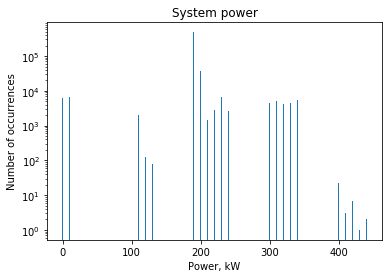

In [27]:
counter = collections.Counter(idle_df_cut.sys_power)
fig, ax = plt.subplots()
plt.title('System power')
plt.ylabel('Number of occurrences')
plt.xlabel('Power, kW')
plt.bar([*counter.keys()], [*counter.values()])
plt.yscale('log')
plt.show()

### Narrow the range to [150; 250]

In [28]:
idle_df_prep = idle_df_cut[(idle_df_cut.sys_power < 250) & (idle_df_cut.sys_power > 150)].copy()
print(round(idle_df_cut[(idle_df_cut.sys_power >= 250) | (idle_df_cut.sys_power <= 150)].shape[0]/idle_df_cut.shape[0]*100, 2), 
      '% of values are excluded')

21.75 % of values are excluded


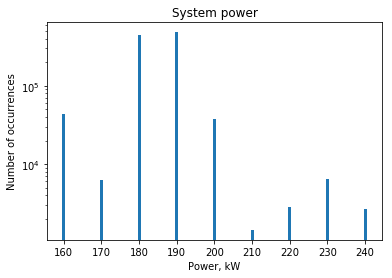

In [29]:
counter = collections.Counter(idle_df_prep.sys_power)
fig, ax = plt.subplots()
plt.title('System power')
plt.ylabel('Number of occurrences')
plt.xlabel('Power, kW')
plt.bar([*counter.keys()], [*counter.values()])
plt.yscale('log')
plt.show()

In [30]:
sample_size = idle_df_prep.shape[0]
sample_size

1024750

------------------------------

Sample size is big enough to use Z-test (normal distribution quantile of 5% to get CI with 95% of confidence)

-----------------

### Calculate average of system power

In [31]:
idle_power_mean = idle_df_prep.sys_power.mean()
idle_power_mean

185.18103927787266

### Confidence interval (CI) for the mean
CI - interval, which will contain true value of the computed statistics (mean) in 100-$\alpha$ of random experiments 

- SEM
- Z-test: the quantile $\delta=1.96$ for 95% confidence level

In [32]:
idle_power_sem = idle_df_prep.sys_power.sem()
idle_power_sem

0.009034445182753953

In [33]:
CI = [idle_power_mean - 1.96 * idle_power_sem, idle_power_mean + 1.96 * idle_power_sem]
print(CI)

[185.16333176531447, 185.19874679043085]


185.18 kW - is assumed further to be the idle power upper limit

---------------

### Calculation of energy consumed in idle mode
Previously found idle power limit is used

In [12]:
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name]
    
    for node in nodes_df_dict_init[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        
        idle_sys_power_ix = np.trim_zeros(np.where(one_node_df.sys_power <= idle_power_mean)[0]).tolist()
        
        time_b = one_node_df.iloc[idle_sys_power_ix,:].unix_timestamp
        time_a = one_node_df.iloc[[x-1 for x in idle_sys_power_ix],:].unix_timestamp
        
        nodes_df_dict_init[df_name].loc['idle_time_sec',node] = \
            (time_b.values - time_a.values).sum()
            
        nodes_df_dict_init[df_name].loc['working_time_sec',node] = \
            one_node_df.unix_timestamp.max() - one_node_df.unix_timestamp.min()
            
        nodes_df_dict_init[df_name].loc['idle_en_integral',node] = \
            forth_integral( y_values=one_node_df.sys_power.iloc[idle_sys_power_ix]/1000.0, \
                            time=( time_b.values - time_a.values )/3600. )

In [15]:
nodes_df_dict_init[df_name].loc[['idle_time_sec', 'working_time_sec', 'idle_en_integral'], :]

,cresco6x001,cresco6x002,cresco6x003,cresco6x004,cresco6x005,cresco6x006,cresco6x007,cresco6x008,cresco6x009,cresco6x010,...,cresco6x207,cresco6x208,cresco6x209,cresco6x210,cresco6x211,cresco6x212,cresco6x213,cresco6x214,cresco6x215,cresco6x216
idle_time_sec,1.708703e+06,1.758580e+06,7.506750e+05,8.626520e+05,9.873380e+05,1.385446e+06,1.277796e+06,1.292701e+06,1.052075e+06,1.459775e+06,...,1.133508e+06,1.780887e+06,1.005422e+06,1.079507e+06,1.093944e+06,1.128989e+06,1.335330e+06,1.218446e+06,1.780887e+06,1.534272e+06
working_time_sec,1.781679e+06,1.781679e+06,1.781679e+06,1.781679e+06,1.781679e+06,1.781679e+06,1.781679e+06,1.781679e+06,1.781679e+06,1.781679e+06,...,1.780888e+06,1.780887e+06,1.780887e+06,1.780887e+06,1.780888e+06,1.780887e+06,1.780887e+06,1.780887e+06,1.780887e+06,1.780888e+06
idle_en_integral,7.292848e+01,7.331893e+01,3.313770e+01,3.792865e+01,4.293975e+01,5.777573e+01,5.197075e+01,5.391126e+01,4.391387e+01,6.085941e+01,...,4.456577e+01,7.420362e+01,4.190575e+01,4.500373e+01,4.363319e+01,4.704121e+01,5.862120e+01,5.076862e+01,6.967289e+01,6.285185e+01


In [30]:
for df_name in nodes_df_names:
    nodes_no_drop_df_dict[df_name].loc[['idle_time_sec', 'working_time_sec', 'idle_en_integral'], :] = \
        nodes_df_dict_init[df_name].loc[['idle_time_sec', 'working_time_sec', 'idle_en_integral'], :]

---------------------------
### Branch. Bins of energy levels

In [29]:
bins = np.arange(0,500,50)

In [30]:
df_name = nodes_df_names[0]

node_df = data_prep_df[df_name].copy()

for node in nodes_df_dict[df_name].columns.values[:1]:
    one_node_df = node_df[node_df.nodename == node].copy()
    groups = one_node_df.groupby(pd.cut(one_node_df.sys_power, bins))
    
energy_level_index = groups.sys_power.sum().index

In [32]:
energy_levels_df_dict = {}

for df_name in nodes_df_names:
    node_df = data_prep_df[df_name].copy()
    energy_levels_df_dict[df_name] = pd.DataFrame(columns = node_names, \
                                                  index = energy_level_index, \
                                                  data=0)

    for node in nodes_df_dict[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()

        groups = one_node_df.groupby(pd.cut(one_node_df.sys_power, bins))
        energy_levels_df_dict[df_name].loc[:, node] = groups.sys_power.count().values

In [33]:
nodes_idle_energy_summary_df = pd.DataFrame(columns = node_names, index = energy_level_index, data=0)
for df_name in nodes_df_names:
    en_node_df = energy_levels_df_dict[df_name]
    nodes_idle_energy_summary_df = en_node_df.replace([np.inf, -np.inf, np.nan], 0).\
                                        add(nodes_idle_energy_summary_df).fillna(en_node_df)
all_entries = nodes_idle_energy_summary_df.sum().sum()
nodes_idle_energy_summary_df.loc[:, 'No_entries_in_total_for_all_months'] = nodes_idle_energy_summary_df.sum(axis=1)
nodes_idle_energy_summary_df.loc[:, 'Percent_entries_in_total_for_all_months'] = \
    nodes_idle_energy_summary_df.filter(regex=('^cresco6x')).sum(axis=1) / all_entries * 100.

nodes_idle_energy_summary_df.Percent_entries_in_total_for_all_months = \
    nodes_idle_energy_summary_df.Percent_entries_in_total_for_all_months.round(2)
nodes_idle_energy_summary_df.to_csv( path_or_buf=os.path.join( Output_dir, 'nodes_idle_energy_summary_no_outliers.csv' ), \
                                     sep=';' )
nodes_idle_energy_summary_df.iloc[:, -2:]

,No_entries_in_total_for_all_months,Percent_entries_in_total_for_all_months
sys_power,,
"(0, 50]",63699,1.33
"(50, 100]",0,0.00
"(100, 150]",1671116,34.91
"(150, 200]",1538534,32.14
"(200, 250]",226702,4.74
"(250, 300]",1097099,22.92
"(300, 350]",155802,3.25
"(350, 400]",29427,0.61
"(400, 450]",4939,0.10


In [34]:
energy_by_month = pd.DataFrame(data=0, index=nodes_df_names, columns=['total_dcenergy_MWh', 'total_sys_energy_MWh'])

for df_name in nodes_df_names:
    energy_by_month.loc[df_name, 'total_dcenergy_MWh'] = nodes_df_dict[df_name].loc['total_dcenergy', :].sum()
    energy_by_month.loc[df_name, 'total_sys_energy_MWh'] = nodes_no_drop_df_dict[df_name].loc['sys_energy', :].sum()
    energy_by_month.loc[df_name, 'idle_energy_MWh'] = nodes_no_drop_df_dict[df_name].loc['idle_en_integral', :].sum()

energy_by_month = energy_by_month/1000.

energy_by_month.loc[:, 'idle_energy_percent_MWh'] = energy_by_month.idle_energy_MWh / \
                                                                energy_by_month.total_sys_energy_MWh * 100.
energy_by_month = energy_by_month.round(3)
energy_by_month.to_csv( path_or_buf=os.path.join( Output_dir, 'energy_summary_by_month_no_outiers.csv' ), sep=';')
energy_by_month

,total_dcenergy_MWh,total_sys_energy_MWh,idle_energy_MWh,idle_energy_percent_MWh
May2018_idle,14.693,15.761,6.841,43.404
June2018_idle,24.173,27.456,15.864,57.780
July2018_idle,21.624,24.611,9.690,39.371
September2018,22.969,25.461,13.657,53.638
October2018,27.048,32.490,12.582,38.726
November2018,26.540,31.381,12.838,40.908
December2018,33.023,37.567,7.617,20.275
January2019,19.393,21.489,9.163,42.637
February2019,21.274,23.778,14.050,59.088


#### Branch finished
------------

### 7. System air flow

In [28]:
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name]
    
    for node in nodes_no_drop_df_dict[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        
        # Read time difference between consecutive measurements 
        # and convert from seconds to minutes
        time_difference = (one_node_df['unix_timestamp'][1:].values -\
            one_node_df.unix_timestamp.iloc[:-1].values) / 60.0
        
        nodes_no_drop_df_dict[df_name].loc['sys_air_flow_CFM', node] = \
            forth_integral(y_values=one_node_df.sysairflow.iloc[1:].values, \
                           time=time_difference)


### 8. Number of measurements for every node per month

In [79]:
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name]
    
    for node in nodes_no_drop_df_dict[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        nodes_no_drop_df_dict[df_name].loc['entries_in_month', node] = one_node_df.shape[0]
        
        nodes_df_dict_init[df_name].loc[temp_type+'_temp_entries_in_month', node] = \
                one_node_df.loc[:, temp_type+'_temp_no_outliers'].dropna().shape[0]
            
        nodes_df_dict_init[df_name].loc[temp_type+'_temp_variation_entries_in_month', node] = \
                one_node_df.loc[:, temp_type+'_temp_variation'].dropna().shape[0]

### -1. Save stats

In [124]:
# nodes_df_dict_init
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
#     nodes_df_dict_init[df_name].to_csv( path_or_buf=os.path.join( Output_dir, nodes_stats_ + 'temp_no_outliers_' + file_name), sep=';' )
    nodes_df_dict_init[df_name].to_csv( path_or_buf=os.path.join( Output_dir, nodes_stats_ + file_name), sep=';' )

In [83]:
# nodes_no_drop_df_dict
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_no_drop_df_dict[df_name].to_csv( path_or_buf=os.path.join( Output_dir, nodes_stats_ + file_name), sep=';' )

-------
### All calculations for nodes stats in one loop

In [189]:
nodes_df_dict_init = {}

for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    
    node_df                     = data_prep_df[df_name].copy()
    nodes_df_dict_init[df_name] = pd.DataFrame(columns = list(node_df.nodename.unique()), \
                                               index = ['total_dcenergy', 'sys_energy', \
                                                        'cpu_energy', 'mem_energy', 'other_energy', \
                                                        'cpu_en_percent', 'mem_en_percent', \
                                                        'other_en_percent', 'sys_util', 'mem_util', 'cpu_util', \
                                                        'other_util','sys_power_max', 'cpu_power_max',\
                                                        'mem_power_max', 'dcenergy_error_percent'], 
                                               data = 0)
    
    for node in nodes_df_dict_init[df_name].columns.values:
        one_node_df = node_df[node_df.nodename == node].copy()
        
        #8 Number of node measurements made during one month
        nodes_df_dict_init[df_name].loc['entries_in_month', node] = one_node_df.shape[0]
        
        #2 Time difference for power integral
        time_difference = (one_node_df['unix_timestamp'][1:].values -\
            one_node_df['unix_timestamp'][:-1].values)/3600.0

        for util_type in ['cpu', 'mem', 'sys']:
            #2 Integrate system power over time
            nodes_df_dict_init[df_name].loc[util_type + '_energy', node] = \
                forth_integral(y_values=one_node_df.iloc[1:,:][util_type + '_power'].values/1000.0,\
                               time=time_difference)

            #4 Find max power utilization by CPU, mem and system
            max_val = one_node_df.loc[:,util_type + '_power'].max() 
            if nodes_df_dict_init[df_name].loc[util_type + '_power_max', node] < max_val:
                nodes_df_dict_init[df_name].loc[util_type + '_power_max', node] = max_val
        
        #1 Energy meter increase
        nodes_df_dict_init[df_name].loc['total_dcenergy', node] = \
            node_df[node_df.nodename == node]['dcenergy'].values[-1] - \
            node_df[node_df.nodename == node]['dcenergy'].values[0]
    
        #2 Integral of sys power vs dcenergy meter error in %
        nodes_df_dict_init[df_name].loc['dcenergy_error_percent', node] = \
            error_percentage(nodes_df_dict_init[df_name].loc['total_dcenergy',node], \
                             nodes_df_dict_init[df_name].loc['sys_energy', node])
            
        #5 Average exhaust, inlet, CPU 1, CPU 2 temperature
        one_node_right_temp_df = one_node_df[(one_node_df.exh_temp>=one_node_df.inlet_temp) &\
                                             (one_node_df.exh_temp>0.) & (one_node_df.inlet_temp>0.) &\
                                             (one_node_df.cpu1_temp>0.) & (one_node_df.cpu2_temp>0.)].copy()
        one_node_right_temp_df.columns = one_node_right_temp_df.columns.str.replace('amb_temp', 'inlet_temp')
        for temp_type in temp_types:
            
            #5.1 Average exhaust, inlet, CPU 1, CPU 2 temperature - no outliers
            nodes_df_dict_init[df_name].loc['avg_'+temp_type+'_temp', node] = \
                one_node_df[temp_type+'_temp'].mean()
                
            nodes_df_dict_init[df_name].loc['std_'+temp_type+'_temp', node] = \
                one_node_df[temp_type+'_temp'].std()
            
            nodes_df_dict_init[df_name].loc[temp_type+'_temp_entries_in_month', node] = \
                one_node_df.loc[:, temp_type+'_temp'].dropna().shape[0]
                
            nodes_df_dict_init[df_name].loc['avg_'+temp_type+'_temp_variation', node] = \
                one_node_df[temp_type+'_temp_variation'].mean()
                
            nodes_df_dict_init[df_name].loc['std_'+temp_type+'_temp_variation', node] = \
                one_node_df[temp_type+'_temp_variation'].std()
                
            nodes_df_dict_init[df_name].loc[temp_type+'_temp_variation_entries_in_month', node] = \
                one_node_df.loc[:, temp_type+'_temp_variation'].dropna().shape[0]
                
        #6 Idle stats
        idle_sys_power_ix = np.trim_zeros(np.where(one_node_df.sys_power <= idle_power_mean)[0]).tolist()
        
        time_b = one_node_df.iloc[idle_sys_power_ix,:].unix_timestamp
        time_a = one_node_df.iloc[[x-1 for x in idle_sys_power_ix],:].unix_timestamp
        
        nodes_df_dict_init[df_name].loc['idle_time_sec',node] = \
            (time_b.values - time_a.values).sum()
            
        nodes_df_dict_init[df_name].loc['working_time_sec',node] = \
            one_node_df.unix_timestamp.max() - one_node_df.unix_timestamp.min()
            
        nodes_df_dict_init[df_name].loc['idle_en_integral',node] = \
            forth_integral( y_values=one_node_df.sys_power.iloc[idle_sys_power_ix].values/1000.0, \
                            time=( time_b.values - time_a.values )/3600. )
            
        time_difference_sys_air = (one_node_df['unix_timestamp'][1:].values -\
            one_node_df.unix_timestamp.iloc[:-1].values) / 60.0
        
        #7 Sys air flow
        nodes_df_dict_init[df_name].loc['sys_air_flow_CFM', node] = \
            forth_integral(y_values=one_node_df.sysairflow.iloc[1:].values, \
                           time=time_difference_sys_air)
            
    #2 Energy used for purposes other than CPU and memory
    nodes_df_dict_init[df_name].loc['other_energy', :] = nodes_df_dict_init[df_name].loc['sys_energy', :] - \
        nodes_df_dict_init[df_name].loc['cpu_energy', :] - nodes_df_dict_init[df_name].loc['mem_energy', :]
        
    #3 Energy portion used for CPU and memory in overall the system energy consumption
    for util_type in ['cpu', 'mem', 'other']:
        nodes_df_dict_init[df_name].loc[util_type + '_en_percent', :] = \
            percentage(nodes_df_dict_init[df_name].loc[util_type + '_energy',:], \
                       nodes_df_dict_init[df_name].loc['sys_energy', :])
    # Save
    nodes_df_dict_init[df_name].to_csv( path_or_buf=os.path.join( Output_dir, \
                                                                 nodes_stats_ + df_name + name_suffix + '.csv' ), sep=';' )    
    print(df_name)
    
    if ( df_name != 'February2019' ):
        stats_df = pd.read_csv(os.path.join( Output_dir, nodes_stats_ + file_name), \
                                             delimiter=";", header=0, index_col=0)

        print((nodes_df_dict_init[df_name].loc[stats_df.index.values,:] - stats_df).max().max(), '\n')

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\ipykernel_launcher.py:5: RuntimeWarning: invalid value encountered in double_scalars
  """


May2018_idle
0.01265665479627387 



c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\pandas\core\indexing.py:1472: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


June2018_idle
0.012910195263486912 

July2018_idle
0.010812545483947389 

September2018
0.00013132918765634827 

October2018
0.001889300880620226 

November2018
0.000837546262118849 

December2018
0.0010948641597749997 

January2019
0.0017985050576498907 

February2019


--------
## Summary for all nodes over all months
- Resultant dataframe is self-descriptive by its row names
- Each column corresponds to one node characterized by its name
- Last two columns are added for average or total summation over all nodes 

In [10]:
def get_df_index_by_row_labels(df, labels):
    return df.index.intersection(labels)

In [11]:
label = {}

label['avg_weights'] = ['entries_in_month']
label['en_percent']  = ['cpu_en_percent', 'mem_en_percent']


label['temp_variation'] = ['avg_'+ i + '_temp_variation' for i in temp_types]
label['temp']           = ['avg_' + i + '_temp' for i in temp_types]
# label['temp_and_variation'] = label['temp'] + label['temp_variation']

label['temp_avg_weights']           = [i + '_temp_entries_in_month' for i in temp_types]
label['temp_variation_avg_weights'] = [i + '_temp_variation_entries_in_month' for i in temp_types]


label['to_calc_sum'] = ['total_dcenergy', 'sys_energy', 'cpu_energy', 'mem_energy', 'other_energy', \
                        'idle_en_integral', 'present_in_months', 'entries_in_month'] + \
                        label['temp_avg_weights'] + \
                        label['temp_variation_avg_weights']
label['to_calc_avg'] = ['cpu_en_percent', 'mem_en_percent', \
                        'other_en_percent', 'sys_power_max', 'cpu_power_max', \
                        'mem_power_max', 'dcenergy_error_percent',\
                        'sys_util', 'mem_util', 'cpu_util', 'other_util', \
                        'idle_time_sec', 'working_time_sec']

summary_label = label['to_calc_sum'] + label['to_calc_avg'] + \
                label['temp'] + label['temp_variation']

In [12]:
def increment_summary(df, summary, index, to_replace=False):
    if to_replace:
        df.loc[index['to_calc_sum']]      = df.loc[index['to_calc_sum']].replace([np.inf, -np.inf, np.nan], 0)
        df.loc[index['to_calc_avg']]      = df.loc[index['to_calc_avg']].replace([np.inf, -np.inf, np.nan], 0)
        df.loc[index['temp']]             = df.loc[index['temp']].replace([np.inf, -np.inf, np.nan], 0)
        df.loc[index['temp_variation']]   = df.loc[index['temp_variation']].replace([np.inf, -np.inf, np.nan], 0)
        
    df.loc[index['to_calc_avg']]      = df.loc[index['to_calc_avg']].values * \
                                        df.loc[index['avg_weights']].values
    df.loc[index['temp']]             = df.loc[index['temp']].values * \
                                        df.loc[index['temp_avg_weights']].values
    
    df.loc[index['temp_variation']]   = df.loc[index['temp_variation']].values * \
                                        df.loc[index['temp_variation_avg_weights']].values
                                                
    summary.loc[index['to_calc_sum']] = df.loc[index['to_calc_sum']].\
                                               add(summary.loc[index['to_calc_sum']]).fillna(df)
                                               
    summary.loc[index['to_calc_avg']] = df.loc[index['to_calc_avg']].\
                                               add(summary.loc[index['to_calc_avg']]).fillna(df)
                                               
    summary.loc[index['temp']] = df.loc[index['temp']].\
                                               add(summary.loc[index['temp']]).fillna(df)
        
    summary.loc[index['temp_variation']] = df.loc[index['temp_variation']].\
                                               add(summary.loc[index['temp_variation']]).fillna(df)

    return (summary)

In [13]:
node_names[105]

'cresco6x106'

In [14]:
node_names_summary = np.delete(node_names, 105)

nodes_summary_df = pd.DataFrame(columns = node_names_summary, index = summary_label, data=0)
nodes_summary_no_drop_df = nodes_summary_df.copy()

index = {}
for key, value in label.items():
    index[key] = get_df_index_by_row_labels(nodes_summary_df, value)

for df_name in nodes_df_names:
    node_df = nodes_no_drop_df_dict[df_name].copy()
    
    # Add counter of node presence in months to further count average
    node_df.loc['present_in_months', :] = 1
    
    # Fill summary with and without columns to drop: dcenergy based and sys_power integral based datasets
    nodes_summary_no_drop_df = increment_summary(df=node_df.loc[:, node_names_summary], index=index, \
                                                 summary=nodes_summary_no_drop_df, to_replace=True)
        
    # Drop columns where the relative error between 
    # dcenergy and system power integral is high
    to_drop_ix = np.unique(np.append(\
                                     np.where(node_df.loc['dcenergy_error_percent', :].isna())[0], \
                                     np.where(node_df.loc['dcenergy_error_percent', :] > 5.)[0]))
    to_drop = node_df.iloc[:,to_drop_ix].columns.values
    node_df.loc[:,to_drop] = 0
    
    nodes_summary_df = increment_summary(df=node_df.loc[:, node_names_summary], index=index, \
                                         summary=nodes_summary_df, to_replace=False)
    
nodes_summary_no_drop_df.loc['total_dcenergy', :] = 0

In [15]:
# Calc total and avg over all nodes for summary dfs
def summary_calc(df, index):
                
    df.loc[:,'total_all_nodes'] = df.loc[index['to_calc_sum'],:].sum(axis=1)
    df.loc[:,'total_all_nodes'].fillna(0, inplace=True)

    df.loc[index['to_calc_avg'],:'cresco6x216'] = df.loc[index['to_calc_avg'],:'cresco6x216'].values / \
                                                  df.loc[index['avg_weights'],:'cresco6x216'].values
        
    df.loc[index['temp'],:'cresco6x216'] = df.loc[index['temp'],:'cresco6x216'].values / \
                                           df.loc[index['temp_avg_weights'],:'cresco6x216'].values
        
    df.loc[index['temp_variation'],:'cresco6x216'] = df.loc[index['temp_variation'],:'cresco6x216'].values / \
                                                     df.loc[index['temp_variation_avg_weights'],:'cresco6x216'].values
    
    
    df.loc[index['to_calc_avg'],'avg_all_nodes']  = (df.loc[index['to_calc_avg'],:'cresco6x216'].values * \
                                  df.loc['entries_in_month',:'cresco6x216'].values).\
                                    sum(axis=1) \
                                    / df.loc['entries_in_month','total_all_nodes']
            
    df.loc[index['temp_variation'],'avg_all_nodes']  = \
                                 (df.loc[index['temp_variation'],:'cresco6x216'].values * \
                                 (df.loc[index['temp_variation_avg_weights'],:'cresco6x216'].values)).\
                                    sum(axis=1) \
                                    / df.loc[index['temp_variation_avg_weights'],'total_all_nodes'].values
                
    df.loc[index['temp'],'avg_all_nodes']  = \
                                 (df.loc[index['temp'],:'cresco6x216'].values * \
                                  df.loc[index['temp_avg_weights'],:'cresco6x216'].values).\
                                    sum(axis=1) \
                                    / df.loc[index['temp_avg_weights'],'total_all_nodes'].values
    
    df.loc['other_en_percent','avg_all_nodes'] = 100.0 - df.loc[index['en_percent'],'avg_all_nodes'].sum()
    df.loc[:,'avg_all_nodes'].fillna(0, inplace=True)
    return (df)

In [16]:
nodes_summary_no_drop_df = summary_calc(nodes_summary_no_drop_df, index)

nodes_summary_df = summary_calc(nodes_summary_df, index)

In [17]:
nodes_summary_df.to_csv( path_or_buf=os.path.join( Output_dir, \
                                                   'nodes_summary_all_months' + name_suffix + '.csv'), \
                         sep=';' )
nodes_summary_no_drop_df.to_csv( path_or_buf=os.path.join( Output_dir, 
                                                           'nodes_summary_all_months_no_drop' + name_suffix + '.csv' ), \
                                 sep=';' ) 

--------------
## Availability of energy and system power data

#### Average of the relative error between integral of system power and energy meter  

In [35]:
print( nodes_summary_df.loc['dcenergy_error_percent', :].mean(), \
       (nodes_summary_df.loc['dcenergy_error_percent', :] * nodes_summary_df.loc['entries_in_month', :]).sum() / \
          nodes_summary_df.loc['entries_in_month', 'total_all_nodes'])

0.5793205159238085 0.5778587315651492


#### Information of sys_power present for each month

In [36]:
analysis_by_month = pd.DataFrame(data=0, index=nodes_df_names, columns=['dcenergy_present', 'sys_power_present'])

for df_name in nodes_df_names:
    month_df = nodes_no_drop_df_dict[df_name].filter(regex=('energy'), axis=0)
    analysis_by_month.loc[df_name, 'dcenergy_present'] = nodes_df_dict[df_name].shape[1]
    analysis_by_month.loc[df_name, 'sys_power_present'] = len(month_df.columns.values) - month_df.loc[:, month_df.isna().any()].shape[1]
analysis_by_month

,dcenergy_present,sys_power_present
May2018_idle,198,214
June2018_idle,188,214
July2018_idle,187,214
September2018,192,214
October2018,178,214
November2018,180,213
December2018,186,213
January2019,193,213
February2019,192,213


In [13]:
analysis_by_month.dcenergy_present.mean(), analysis_by_month.sys_power_present.mean()

(187.75, 213.625)

#### Percent of energy measurements close to sys_power integral

In [37]:
# Check if the nodes are excluded because of sys_power missing data are present in dataset working with dcenergy
for df_name in nodes_df_names:
    month_df = nodes_no_drop_df_dict[df_name].filter(regex=('energy'), axis=0)
    nan_cols_sys_energy = month_df.loc[:, month_df.isna().any()].columns.values
    for col in nan_cols_sys_energy:
        if col in nodes_df_dict[df_name].columns.values:
            print(df_name,  month_df.loc[:, month_df.isna().any()].columns.values )
            
print(analysis_by_month.dcenergy_present.min()/216.*100, analysis_by_month.dcenergy_present.max()/216.*100)

82.4074074074074 91.66666666666666


-------------
## Errors in DC energy meter over months concern the following nodes

In [50]:
dcenergy_error_nodes_dict = {}
dcenergy_all_error_nodes = []
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    dcenergy_error_nodes_dict[df_name] = np.where(nodes_no_drop_df_dict[df_name].loc["dcenergy_error_percent", :] > 5.)[0]
    
    node_df = data_prep_df[df_name]
    
    for node in nodes_no_drop_df_dict[df_name].iloc[:, dcenergy_error_nodes_dict[df_name] ].columns.values:
        int_name = int(node.split('x')[-1])
        if not(int_name in dcenergy_all_error_nodes):
            dcenergy_all_error_nodes.append(int_name)

In [51]:
print(list(set(dcenergy_all_error_nodes)))

[1, 2, 4, 5, 7, 9, 10, 11, 12, 13, 15, 16, 18, 20, 21, 23, 24, 26, 27, 29, 30, 31, 32, 33, 34, 35, 37, 38, 39, 40, 42, 44, 45, 47, 52, 53, 54, 55, 58, 59, 60, 61, 64, 65, 66, 67, 68, 71, 72, 73, 77, 78, 79, 82, 83, 91, 92, 93, 94, 96, 98, 100, 101, 102, 105, 107, 108, 112, 115, 117, 118, 119, 120, 121, 124, 127, 131, 134, 135, 137, 139, 140, 141, 146, 150, 151, 154, 158, 160, 162, 163, 164, 169, 170, 172, 173, 175, 176, 177, 179, 181, 182, 187, 191, 195, 197, 198, 203, 204, 206, 208, 210, 211, 213, 215, 216]


In [ ]:
with open(os.path.join( Output_dir,'dcenergy_error_nodes.txt'), "w") as f:
    f.write(str(list(set(dcenergy_all_error_nodes))))

In [ ]:
with open(os.path.join( Output_dir,'dcenergy_error_nodes.csv'),'w') as f:
    w = csv.writer(f)
    w.writerows(dcenergy_error_nodes_dict.keys(), dcenergy_error_nodes_dict)

In [65]:
# %matplotlib inline
plt.ioff()
for file_name, df_name in zip(nodes_file_names, nodes_df_names):
    nodes_stats = nodes_no_drop_df_dict[df_name]
    node_df     = data_prep_df[df_name]
    for node in nodes_stats.iloc[:, dcenergy_error_nodes_dict[df_name]].columns.values:
        int_name = int(node.split('x')[-1])
        fig = node_df[node_df.nodename == node].\
            plot(x='timestamp_py', y='dcenergy', title=df_name+'\nNode '+str(int_name)+' dc_energy').get_figure()
        fig.savefig( os.path.join( Plots_dir, 'Error dcenergy', 'Error_dc_en_' + df_name + '_' + node + '.png' ), dpi=500 )

---------
## Max CPU, system and memory power utilization of nodes over all months

In [38]:
node_max_power = pd.DataFrame(columns = node_names, \
                              index = ['cpu_power_max', 'mem_power_max', 'sys_power_max'], \
                              data=0)
for df_name in nodes_df_names:
    nodes_stats = nodes_no_drop_df_dict[df_name]
    for node in node_names:
        for util_type in ['cpu', 'mem', 'sys']:
            max_val = nodes_stats.loc[util_type + '_power_max', node]
            if node_max_power.loc[util_type + '_power_max', node] < max_val:
                node_max_power.loc[util_type + '_power_max', node] = max_val

In [85]:
node_max_power.to_csv( path_or_buf=os.path.join( Output_dir, 'node_max_power_all_months.csv'), sep=';') 

In [41]:
node_max_power = pd.read_csv( os.path.join( Output_dir, 'node_max_power_all_months.csv'), \
                              delimiter=";", header=0, index_col=0 )
node_max_power

,cresco6x001,cresco6x002,cresco6x003,cresco6x004,cresco6x005,cresco6x006,cresco6x007,cresco6x008,cresco6x009,cresco6x010,...,cresco6x207,cresco6x208,cresco6x209,cresco6x210,cresco6x211,cresco6x212,cresco6x213,cresco6x214,cresco6x215,cresco6x216
cpu_power_max,270.0,290.0,290.0,320.0,280.0,340.0,340.0,340.0,340.0,350.0,...,350.0,340.0,340.0,340.0,340.0,350.0,340.0,340.0,270.0,250.0
mem_power_max,44.0,44.0,43.0,42.0,44.0,44.0,44.0,45.0,41.0,44.0,...,45.0,45.0,43.0,46.0,42.0,44.0,47.0,42.0,18.0,27.0
sys_power_max,350.0,360.0,360.0,360.0,340.0,430.0,430.0,430.0,440.0,430.0,...,440.0,440.0,440.0,440.0,430.0,440.0,440.0,430.0,320.0,300.0


In [40]:
print('Max system power use observed: \t', node_max_power.loc['sys_power_max',:].max(), \
      '\nMax CPU power use observed: \t', node_max_power.loc['cpu_power_max',:].max(), \
      '\nMax memory power use observed: \t', node_max_power.loc['mem_power_max',:].max())

Max system power use observed: 	 450.0 
Max CPU power use observed: 	 350.0 
Max memory power use observed: 	 255.0


## Correlation between temperature and power utilization or load

In [9]:
corr_df_dict = {}
p_val_df_dict = {}
corr_coeffs = ['pearson', 'kendall']#, 'spearman'] 
temp_types = ['exh', 'inlet', 'cpu1', 'cpu2']
util_types = ['cpu', 'mem', 'sys']
iterables = [ corr_coeffs, [x+'_temp' for x in temp_types], nodes_df_names ]
# [x+'_temp' for x in temp_types] + [x+'_power' for x in util_types] 

In [10]:
to_corr = [x+'_temp' for x in temp_types] + [x+'_power' for x in ['mem', 'sys']]#['sysairflow'] + 

In [11]:
for coeff_type in corr_coeffs:
    corr_df_dict[coeff_type] = {}
    p_val_df_dict[coeff_type] = {}
    for var_to_corr in to_corr:
        corr_df_dict[coeff_type][var_to_corr] = pd.DataFrame(index=node_names, columns=nodes_df_names, data=0)
        p_val_df_dict[coeff_type][var_to_corr] = pd.DataFrame(index=node_names, columns=nodes_df_names, data=0)

In [12]:
def correlate(x, y, coeff_type):
    if (coeff_type == 'pearson'):
        return (scipy.stats.pearsonr(x, y))
    elif (coeff_type == 'kendall'):
        return (scipy.stats.kendalltau(x, y))
    elif (coeff_type == 'spearman'):
        return (scipy.stats.spearmanr(x, y))
    else:
        return ('Wrong coefficient type, must be one of ', corr_coeffs)

In [13]:
# Indices of nan, +-inf, 0
def nan_inf_zero_ix(a):
    return (np.where(a.isin([np.nan, np.inf, -np.inf, 0]))[0])

#  function to drop NaN, zero, +-inf
def dropped(a, b):
    to_drop_ix = np.unique(np.append(\
                                     nan_inf_zero_ix(a), \
                                     nan_inf_zero_ix(b)))
    to_drop = a.iloc[to_drop_ix,:].index.values
    return (a.drop(to_drop), b.drop(to_drop))

In [17]:
for coeff_type in corr_coeffs:
    for var_to_corr in to_corr:
        for df_name in nodes_df_names[:-1]:
            node_df         = data_prep_df[df_name].copy()
            
            for node in node_names:
                one_node_df = node_df[node_df.nodename == node].copy()
                x = one_node_df.loc[:, [var_to_corr]].copy()
                y = one_node_df.loc[:, ['cpu_power']].copy()
                
                if (x.shape[0] == np.where(x.isin([np.nan, np.inf, -np.inf, 0]))[0].size):
                    corr, p_val = 0, 0
                else:
                    x, y = dropped(x, y)
                    corr, p_val = correlate(x, y, coeff_type)
                
                corr_df_dict[coeff_type][var_to_corr].loc[node, df_name] = corr
                p_val_df_dict[coeff_type][var_to_corr].loc[node, df_name] = p_val
                
            corr_df_dict[coeff_type][var_to_corr].loc[:, 'avg_'+coeff_type+'_corr'] = \
                corr_df_dict[coeff_type][var_to_corr].fillna(0).mean(axis=1)

c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\stats.py:3033: RuntimeWarning: Mean of empty slice.
  mx = x.mean()
c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\numpy\core\_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\stats.py:3034: RuntimeWarning: Mean of empty slice.
  my = y.mean()
c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\stats.py:3038: RuntimeWarning: invalid value encountered in true_divide
  r = r_num / r_den
c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\stats.py:3042: RuntimeWarning: invalid value encountered in greater
  r = max(min(r, 1.0), -1.0)
c:\users\aagri\appdata\local\programs\python\python35\lib\site-packages\scipy\stats\stats.py:3042: RuntimeWarning: invalid value encountered in

In [18]:
corr_df_dict[coeff_type][var_to_corr]

,May2018_idle,June2018_idle,July2018_idle,September2018,October2018,November2018,December2018,January2019,February2019,avg_kendall_corr
cresco6x001,0.993094,0.988543,0.916242,0.892917,0.957023,0.357501,0.840937,0.941714,0.928766,0.857077
cresco6x002,0.624653,0.939112,NaN,0.992717,0.959198,0.962680,0.914922,0.881043,0.950444,0.791827
cresco6x003,0.987997,0.985859,0.157321,0.922876,0.911197,0.964924,0.926538,0.938746,0.962926,0.850464
cresco6x004,0.640259,0.907834,0.035156,0.996249,0.460869,0.958239,0.921123,0.949176,0.973168,0.748548
cresco6x005,0.993857,0.996956,0.865958,0.993468,0.452402,0.962129,0.928518,0.960157,0.904434,0.883506
cresco6x006,0.995359,0.953052,0.982749,0.959078,0.852930,0.886010,0.906800,0.804877,0.591677,0.871333
cresco6x007,0.991067,0.995730,0.973094,0.938200,0.874033,0.860281,0.889224,0.794932,0.727132,0.883817
cresco6x008,0.995520,0.989028,0.971796,0.979551,0.950533,0.961183,0.903924,0.972414,0.970756,0.954151
cresco6x009,0.996347,0.992890,0.910083,0.979520,0.964492,0.956285,0.882764,0.926769,0.813448,0.924448
cresco6x010,0.989746,0.962313,0.976628,0.957378,0.868664,0.913943,0.887042,0.719620,0.655917,0.872156


### Save correlation tables

In [19]:
for coeff_type in corr_coeffs:
    for var_to_corr in to_corr:
        corr_df_dict[coeff_type][var_to_corr].\
            to_csv( path_or_buf=os.path.join( Output_dir, coeff_type + '_' + var_to_corr + '.csv' ), sep=';' )
        p_val_df_dict[coeff_type][var_to_corr].\
            to_csv( path_or_buf=os.path.join( Output_dir, coeff_type + '_' + var_to_corr + '_p_value.csv' ), sep=';' )

In [281]:
# # Show correlation and p-value tables 
# corr_coeff = 'pearson'#pearson kendall
# var_to_corr = 'cpu2_temp'
# high_corr_ix = np.unique(np.where(abs(corr_df_dict['pearson']['exh_temp']) >= 0.5)[0])
# round(corr_df_dict[corr_coeff][var_to_corr][high_corr_ix], 2).replace([np.nan], '')

In [282]:
# p_val_df_dict[corr_coeff][var_to_corr].mean()

How to finalize and use model for prediction

https://machinelearningmastery.com/make-predictions-scikit-learn/

scipy.stats.~

- pearsonr(x, y)	Calculates a Pearson correlation coefficient and the p-value for testing non-correlation.
- spearmanr(a[, b, axis, nan_policy])	Calculates a Spearman rank-order correlation coefficient and the p-value to test for non-correlation.
- pointbiserialr(x, y)	Calculates a point biserial correlation coefficient and its p-value.
- kendalltau(x, y[, initial_lexsort, nan_policy])	Calculates Kendall’s tau, a correlation measure for ordinal data.

----------------
## Thermal metrics calculation

- Supply temperature - CRAC unit output air temperature
- Inlet temperature - temperature at the inlet of a node (T_supply <= T_inlet)
- Return temperature - CRAC unit inpute air temperature
- Exhaust temperature - (output temperature) temperature at the rear of a node


Three scenarios are used:
1. Minimal load = high allowable inlet temperature = small_ITE_temp_rise
    - T_supply = max_temp = 18
    - T_return = 24
    
2. Moderate load = moderate allowable inlet temperature = real
    - T_supply = real_temp = 16.5, T_supply <= T_inlet
        
    If T_supply > T_inlet and:
        
        - T_inlet $\in$ [15, 15.6]   => T_supply = 15
        - T_inlet $\in$ (15.6, 16.5] => T_supply = 15.6
        - T_inlet $\in$ (16.5, 18]   => T_supply = 16.5
        
    - T_return = 25
    
3. Maximal load = low allowable inlet temperature = big_ITE_temp_rise
    - T_supply = min_temp = 15
    - T_return = 26

Minimal inlet temperature for every month - below

In [202]:
for df_name in nodes_df_names:
    node_df = data_prep_df[df_name]
    print(node_df.inlet_temp[node_df.inlet_temp>0].dropna().min())

16.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0
15.0


In [203]:
def form_supply_temp( inlet_temp, scenario='real', ):
    scenario_list = ['small_ITE_temp_rise', 'big_ITE_temp_rise', 'real']
    if scenario not in scenario_list:
        raise ValueError("Invalid scenario. Expected one of: %s" % scenario_list)
    
    default_temp  = 0
    min_temp      = 15.0
    min_real_temp = 15.6
    real_temp     = 16.5
    max_temp      = 18
    
    if ( scenario == 'small_ITE_temp_rise' ):
        default_temp = max_temp
    elif ( scenario == 'big_ITE_temp_rise' ):
        default_temp = min_temp
    elif ( scenario == 'real' ):
        default_temp = real_temp
          
    supply_temp = pd.Series(index = inlet_temp.index, data = default_temp)
    
    supply_temp[(inlet_temp < min_real_temp) & (supply_temp > inlet_temp)] = min_temp
    supply_temp[(inlet_temp >= min_real_temp) & (inlet_temp < real_temp) & (supply_temp > inlet_temp)] = min_real_temp
    supply_temp[(inlet_temp >= real_temp) & (inlet_temp < max_temp) & (supply_temp > inlet_temp)] = real_temp
    
    return supply_temp

In [204]:
# Real

scenario_types = ['small_ITE_temp_rise', 'big_ITE_temp_rise', 'real']
return_temp = {}
return_temp['real'] = 25.
return_temp['small_ITE_temp_rise'] = 24.
return_temp['big_ITE_temp_rise'] = 26.

scenario_real = 'real'

In [205]:
metrics = {}
_no_outliers = ''
# _no_outliers = '_no_outliers'
temp_all = {'A1': {'max' : 32, 'min' : 15}, \
            'A2': {'max' : 35, 'min' : 10} }
temp_rec = {'max': 27, 'min': 18}


for scenario_type in scenario_types:
    metrics[scenario_type] = pd.DataFrame( columns = ['RTI', 'RHI', 'SHI'], index = nodes_df_names, data=0 )
    for df_name in nodes_df_names:
        node_df = data_prep_df[df_name]

        supply_temp_values = form_supply_temp( node_df.loc[:, 'inlet_temp' + _no_outliers], scenario_type )
        t_supply = supply_temp_values.mean()
        t_return = return_temp[scenario_type]
        t_inlet  = node_df.loc[:, 'inlet_temp' + _no_outliers].mean()
        t_out    = node_df.loc[:, 'exh_temp' + _no_outliers].mean()
        delta_t  = ( node_df.loc[:, 'exh_temp' + _no_outliers] - node_df.loc[:, 'inlet_temp' + _no_outliers] ).mean()
        
        metrics[scenario_type].loc[df_name, 'RTI']  = ( t_return - t_supply ) / delta_t * 100.
        
        delta_q_temp = ( node_df.loc[:, 'inlet_temp' + _no_outliers] - supply_temp_values ).sum()
        q_total_temp = ( node_df.loc[:, 'exh_temp' + _no_outliers] - supply_temp_values ).sum()
        
        metrics[scenario_type].loc[df_name, 'SHI']  = delta_q_temp / q_total_temp
        metrics[scenario_type].loc[df_name, 'RHI']  = 1 - metrics[scenario_type].loc[df_name, 'SHI']
        metrics[scenario_type].loc[df_name, 'beta'] = ( t_inlet - t_supply ) / delta_t
        metrics[scenario_type].loc[df_name, 'BP']   = ( t_out - t_return ) / ( t_out - t_inlet )
        metrics[scenario_type].loc[df_name, 'R']    = ( t_inlet - t_supply ) / ( t_return - t_supply )
        metrics[scenario_type].loc[df_name, 'BAL']  = (t_out - t_inlet) / ( t_return - t_supply )
        
        n_inlet   = np.unique(node_df.nodename).size
        t_x_max   = np.array([ node_df[ ( node_df.nodename == node ) & \
                                        ( node_df.loc[:, 'inlet_temp' + _no_outliers] > temp_rec['max'] )].\
                               loc[:, 'inlet_temp' + _no_outliers].mean() \
                               for node in np.unique( node_df.nodename )])
        t_x_max   = t_x_max[~np.isnan(t_x_max)]

        t_x_min   = np.array([ node_df[ ( node_df.nodename == node ) & \
                                        ( node_df.loc[:, 'inlet_temp' + _no_outliers] < temp_rec['min'] )].\
                               loc[:, 'inlet_temp' + _no_outliers].mean() \
                               for node in np.unique( node_df.nodename )])
        t_x_min   = t_x_min[~np.isnan(t_x_min)]
        
        metrics[scenario_type].loc[df_name, 'RCI_high_A1'] = \
            ( 1 - \
            ( t_x_max - temp_rec['max'] ).sum() / \
            ( n_inlet * ( temp_all['A1']['max'] - temp_rec['max'] ))) * 100.
        metrics[scenario_type].loc[df_name, 'RCI_low_A1'] = \
            ( 1 - \
            ( temp_rec['min'] - t_x_min ).sum() / \
            ( n_inlet * ( temp_rec['min'] - temp_all['A1']['min'] ))) * 100.
        metrics[scenario_type].loc[df_name, 'RCI_high_A2'] = \
            ( 1 - \
            ( t_x_max - temp_rec['max'] ).sum() / \
            ( n_inlet * ( temp_all['A2']['max'] - temp_rec['max'] ))) * 100.
        metrics[scenario_type].loc[df_name, 'RCI_low_A2'] = \
            ( 1 - \
            ( temp_rec['min'] - t_x_min ).sum() / \
            ( n_inlet * ( temp_rec['min'] - temp_all['A2']['min'] ))) * 100.

In [206]:
metrics['small_ITE_temp_rise']

,RTI,RHI,SHI,beta,BP,R,BAL,RCI_high_A1,RCI_low_A1,RCI_high_A2,RCI_low_A2
May2018_idle,31.422733,0.981507,0.018493,0.018827,0.704599,0.059915,3.182407,100.000000,66.330565,100.00000,87.373962
June2018_idle,31.930125,0.980247,0.019753,0.020141,0.700840,0.063077,3.131848,99.906977,66.050646,99.94186,87.268992
July2018_idle,31.946485,0.979449,0.020551,0.020956,0.701492,0.065599,3.130235,100.000000,66.811372,100.00000,87.554265
September2018,34.457109,0.979244,0.020756,0.021094,0.676550,0.061218,2.902400,100.000000,66.541705,100.00000,87.453139
October2018,36.939508,0.977242,0.022758,0.023169,0.653801,0.062722,2.707337,100.000000,66.564063,100.00000,87.461524
November2018,40.326819,0.975661,0.024339,0.024422,0.621166,0.060561,2.479814,100.000000,64.816048,100.00000,86.806018
December2018,40.635357,0.976400,0.023600,0.023710,0.617359,0.058349,2.460928,100.000000,65.134272,100.00000,86.925352
January2019,40.404849,0.974511,0.025489,0.025692,0.621676,0.063585,2.475169,100.000000,64.102478,100.00000,86.538429
February2019,38.898265,0.973090,0.026910,0.024064,0.636306,0.061864,2.579465,100.000000,61.909181,100.00000,85.715943


In [207]:
# Create a Pandas Excel writer using XlsxWriter as the engine.
writer = pd.ExcelWriter( os.path.join( Output_dir, 'metrics_dict' + name_suffix + '.xlsx'), engine='xlsxwriter')

# Write each dataframe to a different worksheet.
for scenario_type in scenario_types:
    metrics[scenario_type].to_excel(writer, sheet_name=scenario_type)#, header=False

# Close the Pandas Excel writer and output the Excel file.
writer.save()

#### Find nodes and time with abrupt temperature variation - done and discarded

1. Study fluctuations of temperature by node
    - Clean the values: 0, nan, +/-inf -> skip for each temp type 
    - Create a dictionary with node names as keys, and all thermal info about the nodes
        In the rows where the data about one characterisic is not available, insert np.nan for further easier use
    - Add {temp_type}_next_hop columns, for temp_type $\in$ {CPU1, CPU2, amb, exh}
2. Study outliers for future stats tuning - find a range for appropriate thermal values and apply for preprocessed data while calculating stats with the previous algorithm
    - min and max of temp_type fluctuations and temperature occurrences
    
Output:
- more precise temperature graphs and metrics calculations

### Results:
From visualization document and graphs further target characteristics are chosen:
- frequency exh_temp fluctuation values ($t_{current}-t_{prev})$ can be approximated with parametric Cauchy PDF with $x_0 = 0; \; \gamma = IQR(temp\_difference)$
- limitations already exist for stats: > 0, exh > amb
- new limitations for stats:
    - abs(exh_fluct) $\in$ [0,40] when P(exh_fluct) > $10^{-5}$
    - abs(inlet_fluct) < 10
    - abs(CPU1_fluct)

#### Explore dates and ranges of fluctuations

In [88]:
all_nodes_temp_fluct_dict = {}

for node in node_names:
    one_node_df = all_nodes_dict[node]
    for temp_type in temp_types:
        one_node_temp_df = one_node_df.copy()
        one_node_temp_df = one_node_temp_df[~one_node_temp_df.loc[:,temp_type + '_temp'].isin([0, np.nan, np.inf, -np.inf])]
        temp_difference = ( one_node_temp_df[temp_type+'_temp'][1:].values - \
                            one_node_temp_df[temp_type+'_temp'][:-1].values )
        time_difference = ( one_node_temp_df['unix_timestamp'][1:].values - \
                            one_node_temp_df['unix_timestamp'][:-1].values )
        
        # Temperature hop abs > 5, time difference between measurements < 30 min
        fluctuations_ix = np.where( ( abs(temp_difference) > 5 ) & ( time_difference < 30*60 ) )[0]
        fluctuations_and_next_ix = np.unique( np.append( fluctuations_ix, ( fluctuations_ix + 1 ))).tolist()
        one_node_temp_df.loc[:, temp_type'_temp_next_hop'] = 'N/A'
        one_node_temp_df.iloc[:-1,-1] = temp_difference.tolist()
        all_nodes_temp_fluct_dict[node] = one_node_temp_df.iloc[list( sorted( fluctuations_and_next_ix )), :].copy()
        all_nodes_temp_fluct_dict[node].loc[fluctuations_and_next_ix, \
                                            'exh_temp_next_hop'] = temp_difference[fluctuations_and_next_ix].tolist()

#### Rename files

In [10]:
name_suffix = '_temp_no_outliers'
name_suffix_rename = 'temp_no_outliers_'
for df_name, filename in zip(nodes_df_names, nodes_file_names): 
    dst = nodes_stats_ + df_name + name_suffix + '.csv'
    src = 'nodes_stats_' + name_suffix_rename + filename

    # rename() function will 
    # rename all the files 
    os.rename(os.path.join( Output_dir, src ), os.path.join( Output_dir, dst )) 

# src = 'new_nodes_summary_all_months.csv'
# dst = 'nodes_summary_all_months.csv'
# os.rename(os.path.join( Output_dir, src ), os.path.join( Output_dir, dst ))

# src = 'new_nodes_summary_all_months_no_drop.csv'
# dst = 'nodes_summary_all_months_no_drop.csv'
# os.rename(os.path.join( Output_dir, src ), os.path.join( Output_dir, dst )) 